In [1]:
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib
%pip install six
%pip install sklearn
%pip install yellowbrick
%pip install pydotplus
%pip install graphviz
%pip install verta
%pip install Minio
%pip install category_encoders
%pip install watermark
%pip install s3fs


# %pip install modin[ray]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import watermark
# import s3fs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from minio import Minio
from verta import Client
from minio.error import ResponseError
import os
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

# import tools as tools
%matplotlib inline
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [16]:
%watermark -n -v -m -g -iv


Python implementation: CPython
Python version       : 3.7.5
IPython version      : 7.16.1

Compiler    : Clang 11.0.3 (clang-1103.0.32.62)
OS          : Darwin
Release     : 20.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 2ddb6706e28be8b55a0456a8da905ef012b46a7e

sys       : 3.7.5 (default, Jul  7 2020, 21:09:45) 
[Clang 11.0.3 (clang-1103.0.32.62)]
sklearn   : 0.0
numpy     : 1.19.0
matplotlib: 3.3.1
seaborn   : 0.11.0
pandas    : 1.1.4
watermark : 2.1.0



In [17]:
def get_s3_server():
    minioClient = Minio('minio-ml-workshop:9000',
                    access_key='minio',
                    secret_key='minio123',
                    secure=False)

    return minioClient

In [18]:
minioClient = get_s3_server()
data_file = minioClient.fget_object("data", "full_data_csv/data.csv/part-00000-40d2e216-2992-4781-ba15-9789cb64ae30-c000.csv", "/tmp/data.csv")
data_file_version = data_file.version_id
data = pd.read_csv('/tmp/data.csv')
data.head(5)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
data.shape

(7043, 21)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [21]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [22]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Text(0, 0.5, 'Count')

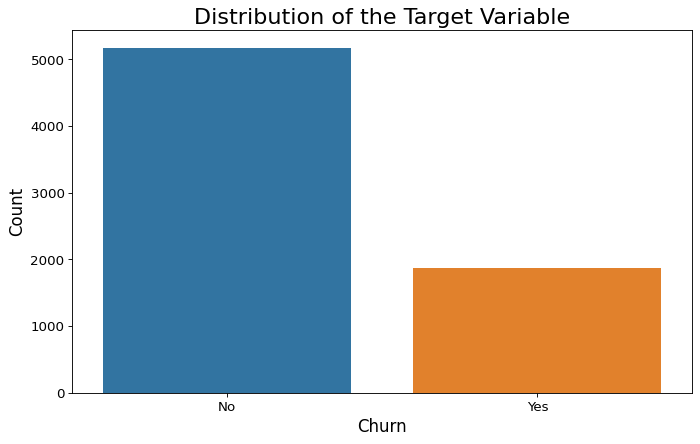

In [23]:
fig = plt.figure(figsize=(10,6), dpi=80)
ax = sns.countplot(x="Churn", data=data)
ax.set_title('Distribution of the Target Variable', fontsize=20)
ax.set_xlabel('Churn', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)

In [24]:
# Convert binary variable into numeric so plotting is easier. We need to later take mean
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

Text(0.5, 1.0, 'Churn count by Contract')

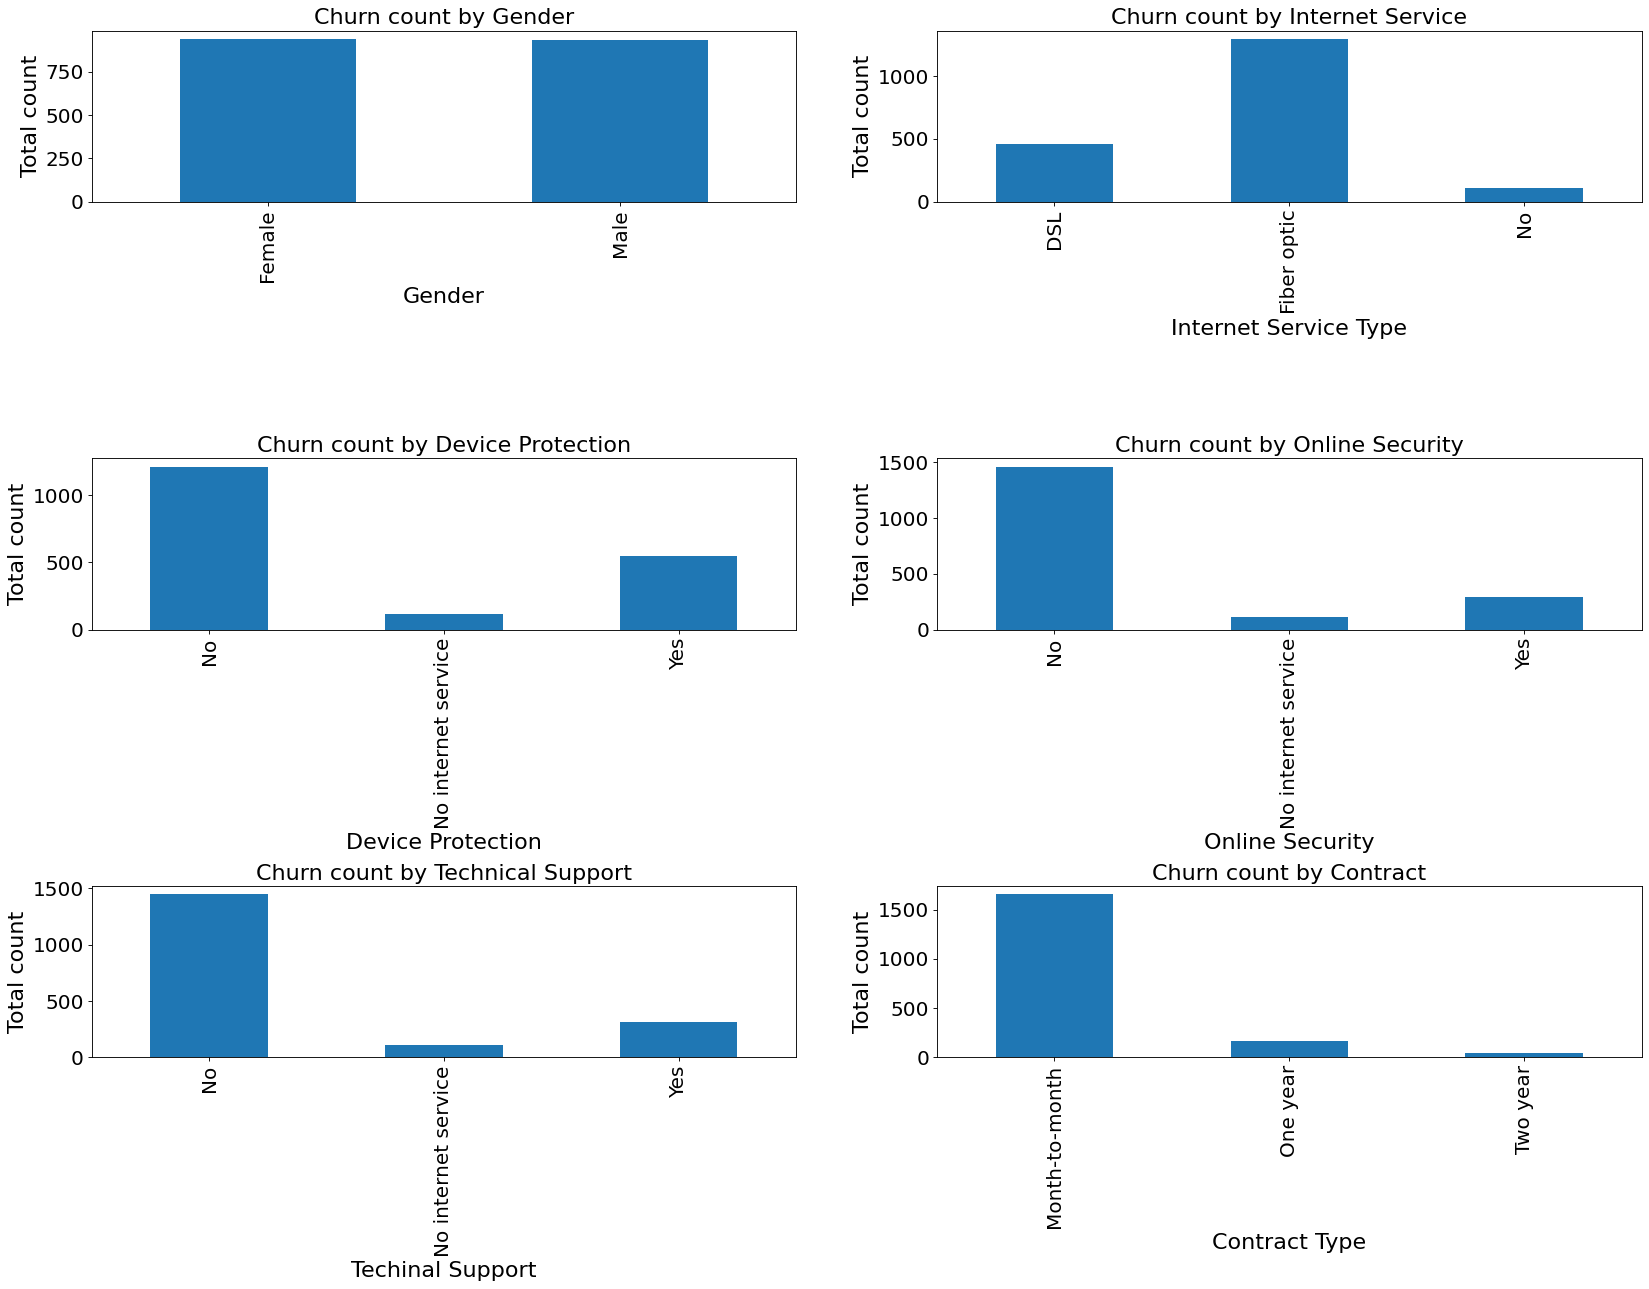

In [25]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(25,17), dpi = 80)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None ,wspace=None, hspace=1.5)
plt.rc('xtick', labelsize = 12)    # fontsize of the tick labels
plt.rc('ytick', labelsize = 12)

data.groupby('gender').Churn.sum().plot(kind='bar', ax = ax1)
ax1.set_ylabel('Total count',fontsize = 20)
ax1.set_xlabel('Gender',fontsize = 20)
ax1.tick_params(labelsize = 18)
ax1.set_title('Churn count by Gender',fontsize = 20)

data.groupby('InternetService').Churn.sum().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Total count',fontsize = 20)
ax2.set_xlabel('Internet Service Type',fontsize = 20)
ax2.tick_params(labelsize = 18)
ax2.set_title('Churn count by Internet Service',fontsize = 20)

data.groupby('DeviceProtection').Churn.sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Total count',fontsize = 20)
ax3.set_xlabel('Device Protection',fontsize = 20)
ax3.tick_params(labelsize = 18)
ax3.set_title('Churn count by Device Protection',fontsize = 20)

data.groupby('OnlineSecurity').Churn.sum().plot(kind='bar', ax=ax4)
ax4.set_ylabel('Total count',fontsize = 20)
ax4.set_xlabel('Online Security',fontsize = 20)
ax4.tick_params(labelsize = 18)
ax4.set_title('Churn count by Online Security',fontsize = 20)

data.groupby('TechSupport').Churn.sum().plot(kind='bar',ax=ax5)
ax5.set_ylabel('Total count',fontsize = 20)
ax5.set_xlabel('Techinal Support',fontsize = 20)
ax5.tick_params(labelsize = 18)
ax5.set_title('Churn count by Technical Support',fontsize = 20)

data.groupby('Contract').Churn.sum().plot(kind='bar',ax=ax6)
ax6.set_ylabel('Total count',fontsize = 20)
ax6.set_xlabel('Contract Type',fontsize = 20)
ax6.tick_params(labelsize = 18)
ax6.set_title('Churn count by Contract',fontsize = 20)


In [26]:
data.replace(" ", np.nan, inplace=True)

In [27]:
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [28]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [29]:
mean = data['TotalCharges'].mean()
data.fillna(mean, inplace=True)
# Now we know that total charges has nan values
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Text(9.942158564814818, 0.5, 'Total Charges')

<Figure size 800x640 with 0 Axes>

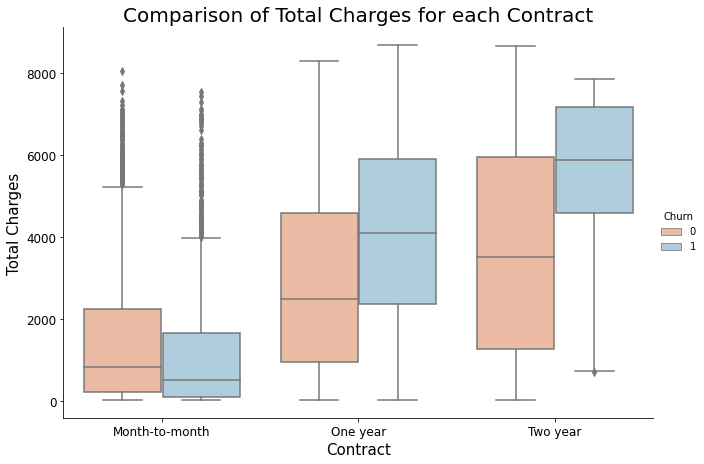

In [30]:
plt.figure(figsize=(10,8), dpi=80)
# Sns.set(rc={'figure.figsize':(25,15)})
ax = sns.catplot(x="Contract", y="TotalCharges", hue="Churn", kind="box", data=data, height = 6,aspect = 1.5,palette = 'RdBu')
plt.title('Comparison of Total Charges for each Contract',fontsize = 20)
plt.xlabel('Contract',fontsize = 15)
plt.ylabel('Total Charges',fontsize = 15)